# SOSE HEAT BUDGET

In [4]:
from dask.distributed import Client

client = Client("tcp://10.32.60.88:43601")
client

Client Scheduler: tcp://10.32.60.88:43601 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 46.00 GB


In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
#example
cat_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml'
cat = intake.Catalog(cat_url)
ds = cat.atmosphere.gmet_v1.to_dask()

In [6]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

##### Another way to load (but slower)
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/SOSE'))

ds

In [7]:
ocean_cat.walk(depth=5)

{'sea_surface_height': name: sea_surface_height
 container: xarray
 plugin: ['zarr']
 description: sea-surface altimetry data from The Copernicus Marine Environment
 direct_access: forbid
 user_parameters: []
 metadata: 
   url: http://marine.copernicus.eu/services-portfolio/access-to-products/?option=com_csw&view=details&product_id=SEALEVEL_GLO_PHY_L4_REP_OBSERVATIONS_008_047
   tags: ['ocean', 'satellite']
 args: 
   urlpath: gcs://pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt
   storage_options: 
     token: anon
   consolidated: True, 'ECCOv4r3': name: ECCOv4r3
 container: xarray
 plugin: ['zarr']
 description: Estimating the Circulation and Climate of the Ocean (ECCO) State Estimate Version 4 Release 3
 direct_access: forbid
 user_parameters: []
 metadata: 
   url: https://ecco-v4-python-tutorial.readthedocs.io/intro.html
   tags: ['ocean', 'model']
 args: 
   urlpath: gcs://pangeo-data/ecco/eccov4r3
   storage_options: 
     token: anon
   consolidated: True, '

In [8]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [9]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic):
  * center   time

# Heat budget for Weddell Gyre

In [10]:
#why does 'isel' take so long to compute with

In [11]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [12]:
surface_mask = (coords.hFacC[0]>0).load()

In [13]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat =-80

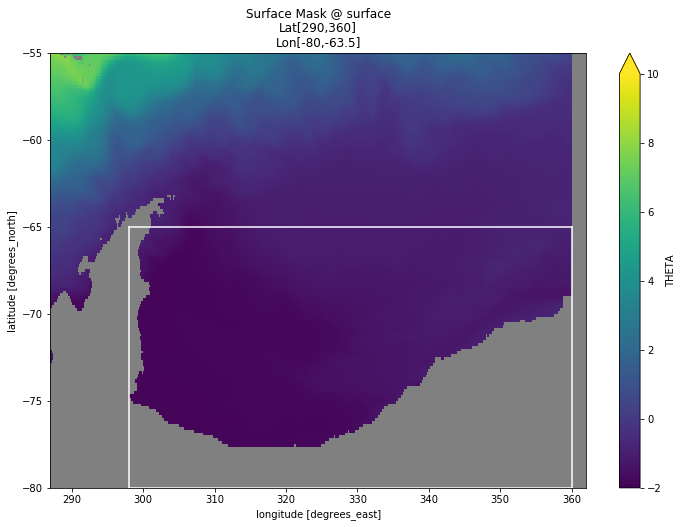

In [14]:
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ surface\nLat[290,360]\nLon[-80,-63.5]');

In [15]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [16]:
dsr.ADVy_TH.sel(YG=upper_lat, method='nearest')

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YG       float32 -64.9583
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [17]:
#advective flux
adv_flux_y = dsr.ADVy_TH.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
adv_flux_x = dsr.ADVx_TH.sel(**lat_range).sel(XG=right_lon, method='nearest').sum(dim=['YC', 'Z']).load()
adv_flux = adv_flux_x + adv_flux_y
adv_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([-13221805., -13907859., -16001169., ..., -13338161.,  -9747787.,
       -11887119.], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [18]:
yg_index = dsr.indexes['YG']
yg_index.get_loc(-60, method='nearest')

108

In [19]:
adv_flux_y

<xarray.DataArray 'ADVy_TH' (time: 438)>
array([ -9628119. , -10594165. , -12933352. , ...,  -9017025. ,  -6285683.5,
        -7320372. ], dtype=float32)
Coordinates:
    YG       float32 -64.9583
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [20]:
#diffusive flux
diff_flux_y = dsr.DFyE_TH.sel(**lon_range).sel(YG=upper_lat, method='nearest').sum(dim=['XC', 'Z']).load()
diff_flux_x = dsr.DFxE_TH.sel(**lat_range).sel(XG=360, method='nearest').sum(dim=['YC', 'Z']).load()
diff_flux = diff_flux_x + diff_flux_y
diff_flux.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ -7607.662, -13723.151,  -6192.76 , ...,  37631.457,  43410.203,
        30665.426], dtype=float32)
Coordinates:
    XG       float32 359.83334
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    YG       float32 -64.9583

In [21]:
#vertical flux
t_flux_z = (dsr.TFLUX.sel(**lat_range, **lon_range) * coords.rA).sum(dim=['XC','YC'])
t_flux_z.load()
#units: W = (kg*m^2)/s^3

<xarray.DataArray (time: 438)>
array([5.490894e+13, 6.297803e+13, 8.621291e+13, ..., 4.101646e+13,
       5.219860e+13, 8.672655e+13], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

In [22]:
coords.rA.sel(YC=-63.5, method='nearest')

<xarray.DataArray 'rA' (XC: 2160)>
dask.array<shape=(2160,), dtype=float32, chunksize=(2160,)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
Attributes:
    coordinate:     YC XC
    long_name:      cell area
    standard_name:  cell_area
    units:          m2

In [23]:
dsr.WTHMASS.sel(YC=-63.4583, method='nearest')

<xarray.DataArray 'WTHMASS' (time: 438, Zl: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -63.541634
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    standard_name:  WTHMASS
    units:          degC.m/s

In [24]:
#linear free surface correction
heat_capacity_cp = 3.994e3 #J/kg*˚C
runit2mass = 1.035e3 #kg/m^3
surface_term = t_flux_z / (heat_capacity_cp * runit2mass)
#units: (˚C m^3)/s

lin_fs_correction = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA
                     ).sel(YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC'])
#lin_fs_correction longitude window is slightly different than other terms
#units: (˚C m^3)/s

In [25]:
surface_term.load()
lin_fs_correction.load()

<xarray.DataArray (time: 438)>
array([-1361935.  ,   348860.16, -1941853.8 , ...,  1623318.  , -3285659.2 ,
        1495456.5 ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

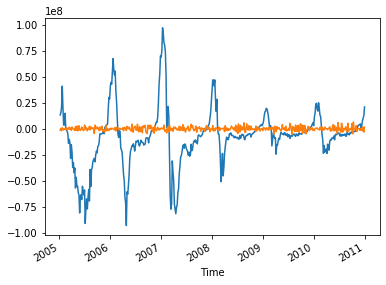

In [26]:
surface_term.plot()
lin_fs_correction.plot()

In [27]:
#is it hFacC or hFacS
total_volume = (coords.rA + coords.drF + coords.hFacC).sum().load()
total_volume

<xarray.DataArray ()>
array(6.010579e+15, dtype=float32)

In [28]:
dsr.TOTTTEND.sel(YC=upper_lat, method='nearest')

<xarray.DataArray 'TOTTTEND' (time: 438, Z: 42, XC: 2160)>
dask.array<shape=(438, 42, 2160), dtype=float32, chunksize=(1, 42, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
    YC       float32 -65.04163
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Tendency of Potential Temperature
    standard_name:  TOTTTEND
    units:          degC/day

In [29]:
tottend_weddell = (dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC
          ).sel(**lon_range, YC=slice(lower_lat, upper_lat)).sum(dim=['XC', 'YC', 'Z']) / (24*60*60)
tottend_weddell.load()
#same longitudinal window as lin_fs_correction (63.541634)
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([20528211.437037, 29680137.860741, 36311992.699259, ..., 22309311.525926,
       21789313.706667, 32536263.49037 ])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

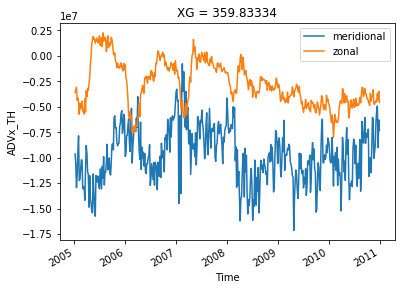

In [30]:
adv_flux_y.plot(label='meridional')
adv_flux_x.plot(label='zonal')
plt.legend();

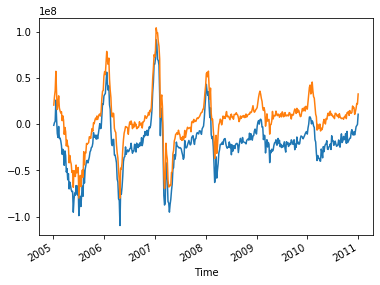

In [31]:
rhs = + adv_flux + diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell
rhs.plot(label='rhs')
lhs.plot()

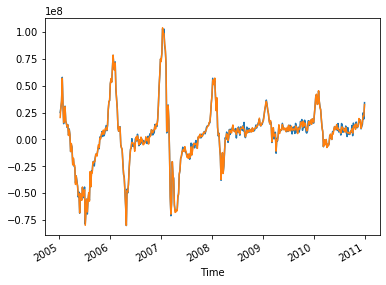

In [32]:
rhs = - adv_flux - diff_flux + lin_fs_correction + surface_term
lhs = tottend_weddell
rhs.plot(label='rhs')
lhs.plot()

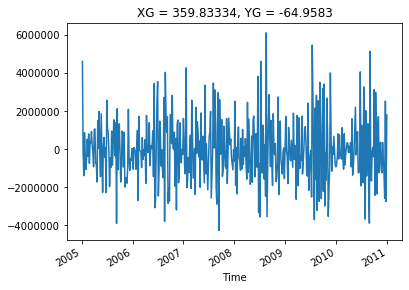

In [33]:
(rhs - lhs).plot()

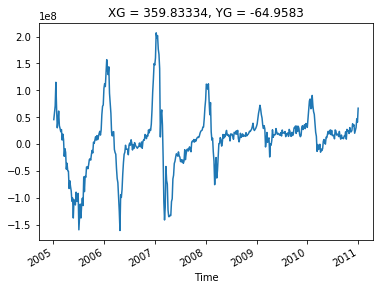

In [43]:
(rhs + lhs).plot()

In [34]:
(rhs - lhs).mean().load()

<xarray.DataArray ()>
array(-26429.637646)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

In [35]:
all_terms = xr.merge([tottend_weddell.rename('tottend'),
                      adv_flux.rename('adv_flux'),
                      diff_flux.rename('diff_flux'),
                      lin_fs_correction.rename('lin_fs'),
                      surface_term.rename('surface')])
all_terms

<xarray.Dataset>
Dimensions:    (time: 438)
Coordinates:
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XG         float32 359.83334
    YG         float32 -64.9583
Data variables:
    tottend    (time) float64 2.053e+07 2.968e+07 ... 2.179e+07 3.254e+07
    adv_flux   (time) float32 -13221805.0 -13907859.0 ... -9747787.0 -11887119.0
    diff_flux  (time) float32 -7607.662 -13723.151 ... 43410.203 30665.426
    lin_fs     (time) float32 -1361935.0 348860.16 ... -3285659.2 1495456.5
    surface    (time) float32 13282954.0 15234938.0 ... 12627299.0 20979914.0

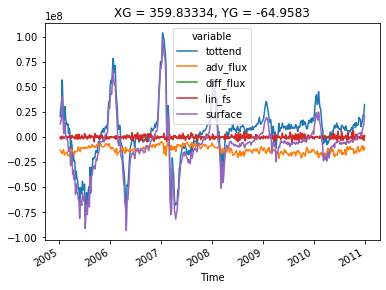

In [36]:
all_terms.to_array().plot.line(x='time')

In [37]:
df = all_terms.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df

,budget
variable,
tottend,4.247488e+06
adv_flux,-1.249413e+07
diff_flux,8.028716e+03
lin_fs,-3.539490e+04
surface,-8.229648e+06


In [44]:
rhs_minus_lhs = df.iloc[0] - df.iloc[1:2].sum() + df.iloc[3:4].sum()
rhs_minus_lhs

budget    1.670622e+07
dtype: float64

In [45]:
budget_diff = rhs.sum() + lhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(3.709223e+09)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

In [47]:
budget_diff = lhs.sum() - rhs.sum()
budget_diff.load()

<xarray.DataArray ()>
array(11576295.288889)
Coordinates:
    XG       float32 359.83334
    YG       float32 -64.9583

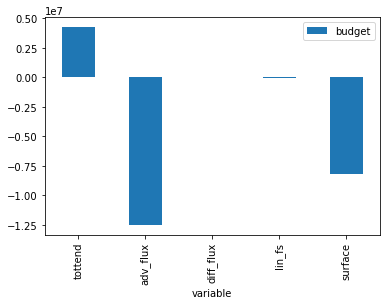

In [40]:
df.plot(kind='bar')

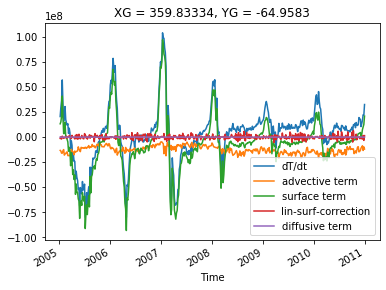

In [41]:
tottend_weddell.plot(label='dT/dt')
adv_flux.plot(label='advective term')
surface_term.plot(label='surface term')
lin_fs_correction.plot(label='lin-surf-correction')
diff_flux.plot(label='diffusive term')
plt.legend();

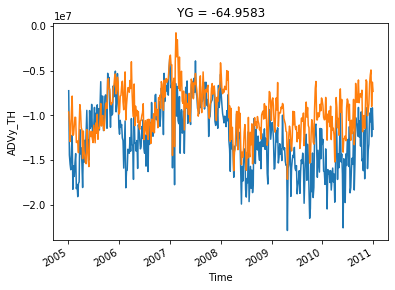

In [42]:
(surface_term - tottend_weddell).plot()
adv_flux_y.plot(label='adv flux y')